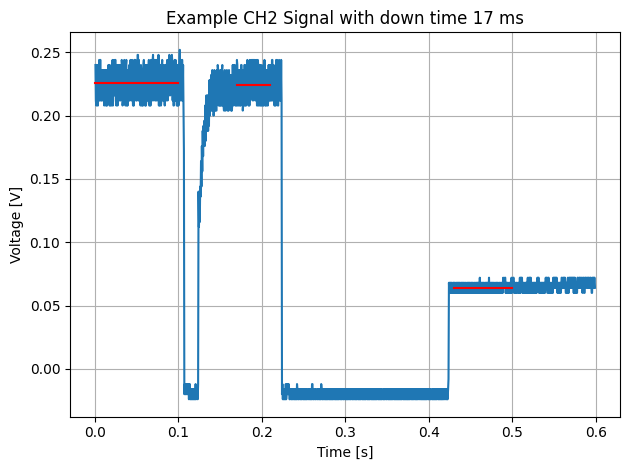

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# Down times we used for the measurements
down_times = 1e-3 * np.array([5,3,7,4,8,10,12,15,17,19, 20, 23, 27, 32, 36, 45, 65, 75, 85])
down_times_ms = down_times * 1e3

# Time stamps we chose by hand
# The time stamps define the time intervals for averaging the measurements
time_stamps = np.array([
    [0.19, 0.22, 0.3, 0.52, 0.56], # 5ms
    [0.18, 0.2, 0.28, 0.5, 0.54], # 3ms
    [0.17, 0.22, 0.28, 0.5, 0.54], # 7ms
    [0.18, 0.21, 0.28, 0.5, 0.55], # 4ms
    [0.1, 0.14, 0.18, 0.43, 0.5], # 8ms
    [0.1, 0.16, 0.21, 0.43, 0.5], #10ms
    [0.1, 0.15,0.2,0.43,0.51], #12ms
    [0.1, 0.17, 0.21, 0.43,0.5], #15ms
    [0.1, 0.17, 0.21, 0.43, 0.5], #17ms
    [0.1, 0.17, 0.21, 0.43, 0.5], #19ms
    [0.095, 0.17, 0.21, 0.43, 0.5], # 20ms
    [0.085, 0.16, 0.21, 0.43, 0.5], # 23ms
    [0.085, 0.16, 0.21, 0.43, 0.5 ], # 27ms
    [0.085, 0.15, 0.21, 0.43, 0.5], # 32ms
    [0.08, 0.15, 0.21, 0.43, 0.5], # 36ms
    [0.16, 0.25, 0.3, 0.52, 0.58], # 45ms
    [0.13, 0.25, 0.3, 0.52, 0.58], # 65ms
    [0.12, 0.25, 0.3, 0.52, 0.58], # 75ms
    [0.12, 0.25, 0.3, 0.52, 0.58], # 85ms
])

avg_ratios = np.zeros(len(time_stamps))
std_ratios = np.zeros(len(time_stamps))
channel = 2

# i is the index of the time stamps
# j_file is the index of the file, since we made 4 measurements for each time stamp
for i in range(0, len(time_stamps)):
    ratio_sum = 0
    for j_file in range(4):
        file_index = i * 4 + j_file + 1
        with open(f"Data/NewFile{file_index}.csv", newline='') as f:
            reader = csv.reader(f)
            next(reader)
            second_row = next(reader)
            increment = float(second_row[-1])
            next(reader)  

            data = []
            for row in reader:
                values = [float(x) for x in row if x.strip()]
                data.append(values)

        data = np.array(data)

        down_time = down_times[i]

        ch = data[:, channel - 1]
        t = np.arange(len(ch)) * increment

        # Calculate the mean values for the left, middle, and offset regions
        mean_left = np.mean(ch[t < time_stamps[i, 0]])
        std_left = np.std(ch[t < time_stamps[i, 0]])
        mean_middle = np.mean(ch[(t > time_stamps[i, 1]) & (t < time_stamps[i, 2])])
        std_middle = np.std(ch[(t > time_stamps[i, 1]) & (t < time_stamps[i, 2])])
        offset = np.mean(ch[(t > time_stamps[i, 3]) & (t < time_stamps[i, 4])])
        std_offset = np.std(ch[(t > time_stamps[i, 3]) & (t < time_stamps[i, 4])])

        N_0 = mean_left - offset
        std_N_0 = np.sqrt(std_left**2 + std_offset**2)
        N_t = mean_middle - offset
        std_N_t = np.sqrt(std_middle**2 + std_offset**2)
        ratio = N_t / N_0
        std_ratio = ratio * np.sqrt((std_N_t / N_t)**2 + (std_N_0 / N_0)**2)
        ratio_sum += ratio

        t_min = 0
        t_max = 1

        index_range = (t > t_min) & (t < t_max) 

        # Plotting the signal and averages for a specific example
        i_example = 8
        if i == i_example and j_file == 0:
            plt.plot(t[index_range], ch[index_range])
            # Plot averages
            plt.plot(t[t < time_stamps[i, 0]], mean_left * np.ones_like(t[t < time_stamps[i, 0]]), 'r')
            plt.plot(t[(t > time_stamps[i, 1]) & (t < time_stamps[i, 2])], mean_middle * np.ones_like(t[(t > time_stamps[i, 1]) & (t < time_stamps[i, 2])]), 'r')
            plt.plot(t[(t > time_stamps[i, 3]) & (t < time_stamps[i, 4])], offset * np.ones_like(t[(t > time_stamps[i, 3]) & (t < time_stamps[i, 4])]), 'r')

            plt.xlabel("Time [s]")
            # Round down times
            plt.title(f"Example CH{channel} Signal with down time {round(down_times_ms[i])} ms")
            plt.ylabel(f"Voltage [V]")
            plt.grid(True)
            plt.tight_layout()
            #plt.savefig(f"CH{channel}_down_time_{round(down_times_ms[i])}.png", dpi=300)
            plt.show()
            
    avg_ratios[i] = ratio_sum / 4  # Average over the 4 measurements for each time stamp
    std_ratios[i] = std_ratio

In [13]:
### Fit the curve
from scipy.special import erf
from scipy.optimize import curve_fit
from IPython.display import display, Math

u = 1.66053906660e-27  # kg
m_85rb = 84.91178974 * u  # kg
k_B = 1.380649e-23  # J/K
R = 0.0125  # m

def f(t, A, T):
    alpha = np.sqrt( (2 * k_B * T) / m_85rb)
    x = R / (alpha * t)
    return A * (erf(x) - 2 / np.sqrt(np.pi) * x * np.exp(-x**2))

popt, pcov = curve_fit(f, down_times, avg_ratios, bounds=(0, [1, 1]), p0=[1, 0.1])

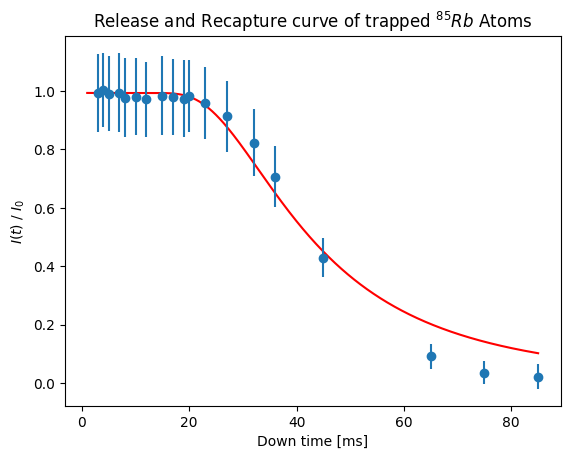

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [14]:
xaxis = np.linspace(0.001, down_times.max(), 1000)
plt.title(rf"Release and Recapture curve of trapped $^{{85}}Rb$ Atoms")
plt.plot(xaxis * 1000, f(xaxis, *popt), color='red', label='Fitted curve')
plt.errorbar(down_times_ms, avg_ratios, yerr=std_ratios, fmt='o', label='Measured data with error bars')
plt.xlabel("Down time [ms]")
plt.ylabel(rf"$I(t)$ / $I_0$")
#plt.savefig("Release_and_Recapture.png", dpi=600)
plt.show()

display(Math(r'''
\frac{N(t)}{N(0)} = \operatorname{erf}(\chi(t)) - \frac{2}{\sqrt{\pi}} \chi(t) e^{-\chi(t)^2}, \quad
\chi(t) = \frac{v_R}{\alpha} = \sqrt{\frac{m}{2k_B T}} v_R = \frac{R}{\alpha t}
'''))
display(Math(rf'\text{{Fitted parameters: }} \quad A = {popt[0]:.4f}, \quad T = {1e3 * popt[1]:.4f} mK'))
display(Math(rf'\text{{Uncertainties: }} \Delta A = {np.sqrt(pcov[0][0]):.4f},\quad \Delta T = {1e3 * np.sqrt(pcov[1][1]):.4f} mK'))
